In [1]:
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt
from main import target_renamer, forecast_maker
from Models.lstm import LSTM

In [2]:
month_data = True #1 month of data for testing new code
month_range = pd.date_range("2018-08-01", "2018-08-31 23:00", freq='h', tz="UTC")
target_month = pd.date_range("2019-08-01", "2019-08-31 23:00", freq='h', tz="UTC")


# 0. Data initialization

## 0.1 Source data

In [3]:
openmeteo = pd.read_pickle("Data/openmeteo.pickle")

pvgis = pd.read_pickle('Data/PVGIS.pickle')
pvgis = pvgis.xs('P', axis=1)
pvgis = pvgis["2016-05-01":"2020-12-31"]
pvgis = pvgis.tz_localize("UTC")



In [4]:
# P = dataset['P']
# P_24h= dataset["P_24h_shift"]
# daterange = pd.date_range("2018-07-02", "2018-07-06", freq='h', tz="UTC")
# plt.figure()
# plt.plot(daterange, P[daterange],color="#11aa00", label="Actual power")
# plt.plot(daterange, P_24h[daterange], color="#11aa0055", label="Power 24h shifted")
# plt.legend()

## 0.2 Target data

In [5]:
installation_id = "3437BD60"
prodNL = pd.read_parquet('Data/production.parquet', engine='pyarrow')
metadata = pd.read_csv("Data/installations Netherlands.csv", sep=';')
metadata = metadata.set_index('id')
metadata_id = metadata.loc[installation_id]
tilt = metadata_id["Tilt"]
peakPower = metadata_id["Watt Peak"]
azimuth = metadata_id["Orientation"]
latitude = metadata_id["Latitude"]
longitude = metadata_id["Longitude"]
power = prodNL.loc[installation_id]
power = target_renamer(power, 'watt')
power = power.resample('h').sum()/4
power = power.tz_localize('UTC')
if month_data:
    target_power = power[power.index.isin(target_month)]
target_power.head()


,P
timestamp,
2019-08-01 00:00:00+00:00,0.0
2019-08-01 01:00:00+00:00,0.0
2019-08-01 02:00:00+00:00,0.0
2019-08-01 03:00:00+00:00,0.0
2019-08-01 04:00:00+00:00,7.0


# 1. Historic weather 

## 1.1 Prepare data

In [6]:
from Data.Featurisation import Featurisation

data = pd.merge(pvgis, openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')


source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]

target_meteo = openmeteo[openmeteo.index.isin(target_month)]
target_dataset = pd.merge(target_power, target_meteo, left_index=True, right_index=True)

data = [target_dataset] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')

target_dataset = data.data[0]


In [7]:
tuning_method = 'whole'
features = list(source_dataset.columns)

## 1.2  Make models

c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_tensor = torch.tensor(self.data[feature]).type(torch.float32)
c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_tensor = torch.tensor(self.data[feature]).type(torch.float32)


Shape of data:  torch.Size([24, 24, 15]) torch.Size([6, 24, 15]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1])
LSTM(
  (lstm): LSTM(15, 100, num_layers=4, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)
Step 0: Average train loss: 0.1549 | Average test loss: 0.1048
Step 5: Average train loss: 0.1173 | Average test loss: 0.0720
Step 10: Average train loss: 0.0371 | Average test loss: 0.0546
Step 15: Average train loss: 0.0215 | Average test loss: 0.0203
Step 20: Average train loss: 0.0232 | Average test loss: 0.0212
Step 25: Average train loss: 0.0222 | Average test loss: 0.0281
Step 30: Average train loss: 0.0200 | Average test loss: 0.0220
Step 35: Average train loss: 0.0194 | Average test loss: 0.0200
Step 40: Average train loss: 0.0185 | Average test loss: 0.0218
Step 45: Average train loss: 0.0189 | Average test loss: 0.0216
Step 50: Average train loss: 0.0186 | Average test loss: 0.0199
Step 55: Average train loss: 0.0169 | Average

c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_tensor = torch.tensor(self.data[feature]).type(torch.float32)
c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_tensor = torch.tensor(self.data[feature]).type(torch.float32)


Shape of data:  torch.Size([24, 24, 15]) torch.Size([6, 24, 15]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1])
LSTM(
  (lstm): LSTM(15, 100, num_layers=4, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)
Step 0: Average train loss: 0.0097 | Average test loss: 0.0040
Step 5: Average train loss: 0.0094 | Average test loss: 0.0041
Step 10: Average train loss: 0.0093 | Average test loss: 0.0040
Step 15: Average train loss: 0.0089 | Average test loss: 0.0037
Step 20: Average train loss: 0.0090 | Average test loss: 0.0037
Step 25: Average train loss: 0.0090 | Average test loss: 0.0036
Step 30: Average train loss: 0.0087 | Average test loss: 0.0038
Step 35: Average train loss: 0.0089 | Average test loss: 0.0036
Step 40: Average train loss: 0.0091 | Average test loss: 0.0036
Step 45: Average train loss: 0.0093 | Average test loss: 0.0035
Step 50: Average train loss: 0.0084 | Average test loss: 0.0036
Step 55: Average train loss: 0.0087 | Average

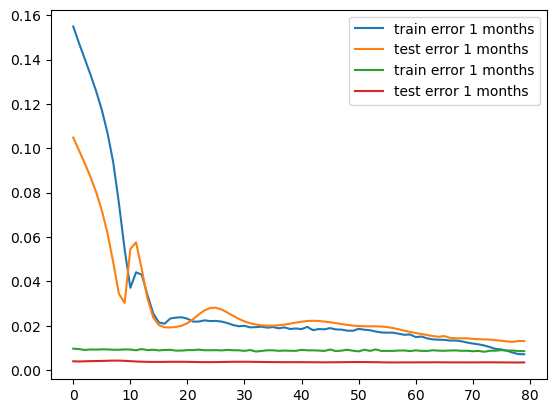

In [8]:

source_state_dict, target_state_dict = forecast_maker(source_dataset, target_dataset, tuning_method, features)